In [495]:
START_TIME = "2018-08-31 06:30:00" # Beginning of the data to analyse
THRESHOLD = -40 # Threshold in dBm

##### Importings

In [496]:
import csv
import json
import psycopg2
from datetime import datetime

##### Initialisations

In [497]:
INVALID_POWER = -256
MAC_directory = {}
data = {}

# Import the private MAC addresses directory
with open("MAC_directory.json", "r") as f:
    MAC_directory = json.load(f)

# Open CSV file
# data_file = open('defaultmeas 31-01-18.csv', 'r')
# data_reader = csv.reader(data_file, delimiter=',')
# next(data_reader) # pass first line "value,time"

##### Connect to database

In [498]:
# Import the database access parameters
db_access = {}
with open("db_access.json", "r") as f:
    db_access = json.load(f)

try:
    conn = psycopg2.connect(dbname=db_access["dbname"], user=db_access["user"], host=db_access["host"], password=db_access["password"])
except Exception as e:
    print("I am unable to connect to the database:", e)
else:
    print("Successfully connected to database")

db_access = None

query = """
SELECT "value", date_part('epoch', time)
FROM public.defaultmeas
WHERE "device" = '72' AND "dttp" = '2' AND "time" >= '""" + START_TIME + """'
ORDER BY "time"
"""
cur = conn.cursor()
cur.execute(query)
rows = cur.fetchall()

Successfully connected to database


##### Create data dictionnary

In [499]:
n_values = 0
n_unknown_power = 0
n_low_power = 0

for row in rows:
    n_values += 1
    
    value = row[0]["value"]

    time = int(float(row[1]))
    power = int(value["power"])
    mac = value["mac"]

    if(power == INVALID_POWER):
        n_unknown_power += 1
    elif(power < THRESHOLD):
        n_low_power += 1
    else:
        data_mac = data.get(mac, None)

        if(data_mac):
            # Note: The 'dict' attribute doesn't store every value
            #       but keep the max power for each second
            old_power = data_mac["dict"].get(time, INVALID_POWER)
            data_mac["dict"][time] = max(power, old_power)
            data_mac["count"] += 1
            data_mac["mean"] = (data_mac["mean"] * (data_mac["count"]-1) + power) / data_mac["count"]
                
            data_mac["squared mean"] = (data_mac["squared mean"] * (data_mac["count"]-1) + power*power) / data_mac["count"]
                
            data_mac["variance"] = data_mac["squared mean"] - data_mac["mean"] * data_mac["mean"]
            data_mac["max power"] = max(power, data_mac["max power"])
            data_mac["min power"] = min(power, data_mac["min power"])
            data_mac["last seen"] = time
        else:
            data[mac] = {
                "dict": {time: power},
                "count": 1,
                "mean": power,
                "squared mean": power*power,
                "variance": 0,
                "max power": power,
                "min power": power,
                "first seen": time,
                "last seen": time
            }
            
# data_file.close()

##### Creates private data with readable dates instead of timestamps

In [500]:
from datetime import datetime

def read_time(timestamp):
    return datetime.utcfromtimestamp(timestamp).strftime('%d-%m-%Y %H:%M:%S')

def date_time(timestamp):
    formatted = read_time(timestamp)
    return datetime.strptime(formatted, '%d-%m-%Y %H:%M:%S')

In [501]:
private_data = { MAC_directory[mac]: data[mac] for mac in MAC_directory if mac in data}

readable_private_data = {}
for mac, value in private_data.items():
    readable_private_data[mac] = {
        # "dict": {read_time(timestamp): power for timestamp, power in value["dict"].items()},
        "count": value["count"],
        "mean": value["mean"],
        # "squared mean": value["squared mean"],
        "variance": value["variance"],
        "max power": value["max power"],
        "min power": value["min power"],
        "first seen": read_time(value["first seen"]),
        "last seen": read_time(value["last seen"])
    }

##### Creates Strings from data

In [502]:
data_json = json.dumps(data, indent=2)
private_data_json = json.dumps(private_data, indent=2)
readable_private_data_json = json.dumps(readable_private_data, indent=2)

In [503]:
# print(readable_private_data_json)

##### Plot graphs

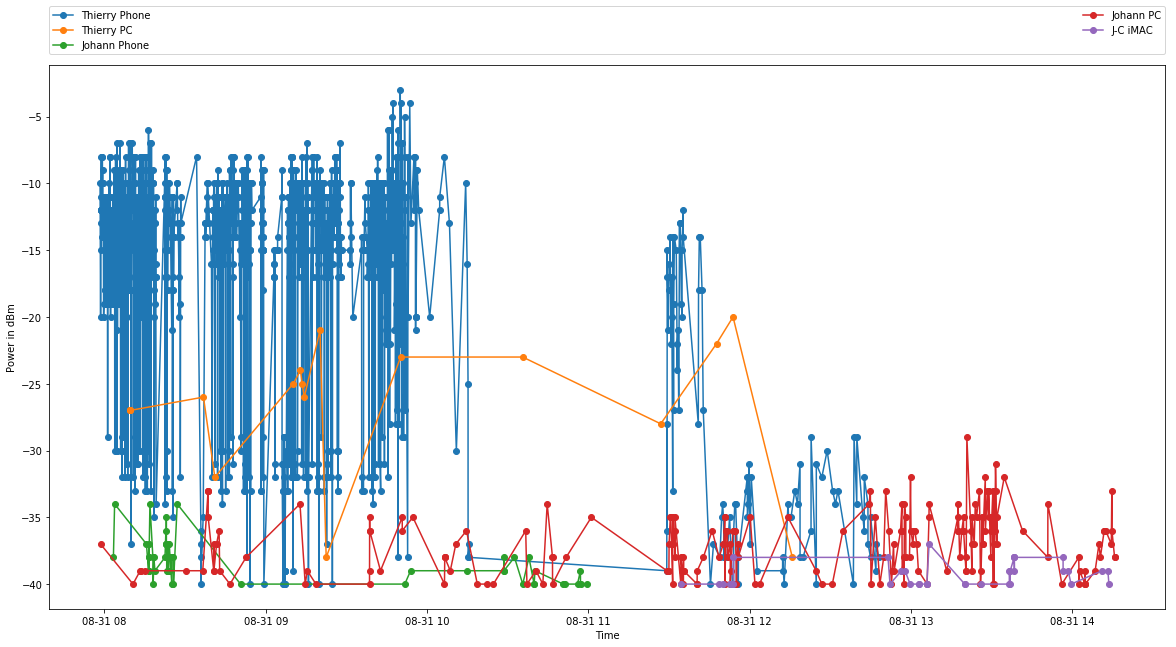

In [504]:
import matplotlib as mpl
import matplotlib.pyplot as plt

for mac, value in private_data.items():
    mac = MAC_directory.get(mac, mac)
    datetimes = [date_time(x) for x in value["dict"].keys()]
    dates = mpl.dates.date2num(datetimes)
    plt.plot_date(dates, value["dict"].values(), label=mac, linestyle='solid') 


plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)

plt.xlabel('Time')
plt.ylabel('Power in dBm')

plt.rcParams["figure.figsize"] = [20,10]

plt.show()